In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import wandb
import custom_loaders
import conv_layers
from tqdm import trange
import matplotlib.pyplot as plt

from utils import show_images, plot_losses_and_fid, get_fid, PILinterpolate

/root/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 256
n_channels = 1

class Args():
    def __init__(self):
        self.dataset = 'GAN'
        self.imagePath = '/root/data/data/chest_xray/train/PNEUMONIA'
        self.image_size = img_size
        self.download = False
        self.imgC = n_channels
        self.num_images = 300
        self.convert2bw = True

train_args = Args()
train_dataset = custom_loaders.get_data_loader(train_args)

## Load test data
test_args = Args()
test_args.imagePath = '/root/data/data/chest_xray/test/PNEUMONIA'
test_dataset = custom_loaders.get_data_loader(test_args)

100%|██████████| 300/300 [00:02<00:00, 136.49it/s]


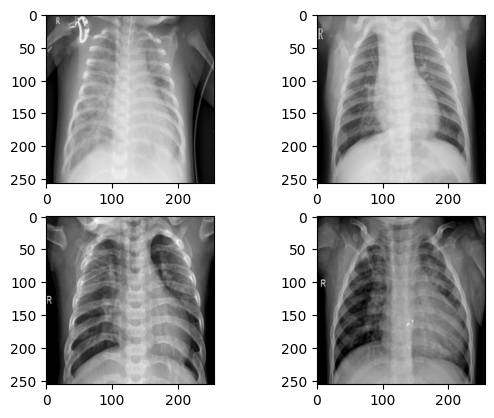

In [3]:
bs = 16
train_loader = data_utils.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = data_utils.DataLoader(test_dataset, batch_size=bs, shuffle=False)

fig, axs = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        axs[i, j].imshow(train_loader.dataset[i*2+j].numpy().squeeze(), cmap='gray')



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_len = 256
channelsD = [latent_len, 256, 256, 128, 128, 128, 64, 32, n_channels]
channelsE = [n_channels, 32, 64, 128, 128, 128, 128, 512, 2*latent_len]

assert(len(channelsE) == len(channelsD))
assert(2**(len(channelsE) - 1) == img_size)

epochs = 10
iter = 0
log = False
log_iter = 10
# wandb.init(project='pytorch-vae', entity='basujindal123')

In [5]:
class VAE(nn.Module):
    def __init__(self, channelsD, channelsE):
        super(VAE, self).__init__()
        self.D = conv_layers.GeneratorUpSample(channelsD)
        self.E = conv_layers.Discriminator(channelsE)

    def forward(self, x):
        z = self.E(x)

        z = z.view(z.shape[0], -1)

        mu, logvar = z[:, :latent_len], z[:, latent_len:]
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        z = z.view(z.shape[0], latent_len, 1, 1)

        x_hat = self.D(z)
        
        return x_hat, mu, logvar


    def sample_images(self, num_imgs):
     
        with torch.no_grad():
            sample = torch.randn(num_imgs, latent_len, 1, 1).to(device)
            sample = self.D(sample).cpu()

        return sample


def train(model, train_loader, optimizer, epoch, device, kl_weight=0.5):
    model.train()
    train_loss_mse = 0
    train_loss_kl = 0
    for batch_idx, data in enumerate(train_loader):
        
        data = data.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(data)
        
        loss_mse = ((data - x_hat)**2).mean()
        loss_kl = kl_weight*(-0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()))

        loss = loss_mse + loss_kl
        
        loss.backward()
        train_loss_mse += loss_mse.item()
        train_loss_kl += loss_kl.item()

        optimizer.step()

    train_loss_mse /= len(train_loader)
    train_loss_kl /= len(train_loader)
    
    # wandb.log({'train_loss_mse': train_loss_mse, 'train_loss_kl': train_loss_kl})
    print('====> Epoch: {} MSE loss: {:.4f} KL loss: {:.4f}'.format(
            epoch, train_loss_mse*100, train_loss_kl*100))
    return train_loss_kl, train_loss_mse


In [6]:
model = VAE(channelsD, channelsE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []
fid_scores = []
    

def evaluation_step(engine, batch):
    with torch.no_grad():
        real = PILinterpolate(batch)
        fake = model.sample_images(num_imgs=batch.shape[0])
        fake = PILinterpolate(fake.cpu())
        return fake, real

  5%|▍         | 1/21 [00:00<00:13,  1.51it/s]

====> Epoch: 1 MSE loss: 7.5344 KL loss: 0.3886


 10%|▉         | 2/21 [00:01<00:12,  1.52it/s]

====> Epoch: 2 MSE loss: 7.4088 KL loss: 0.4075
====> Epoch: 3 MSE loss: 7.5583 KL loss: 0.4059


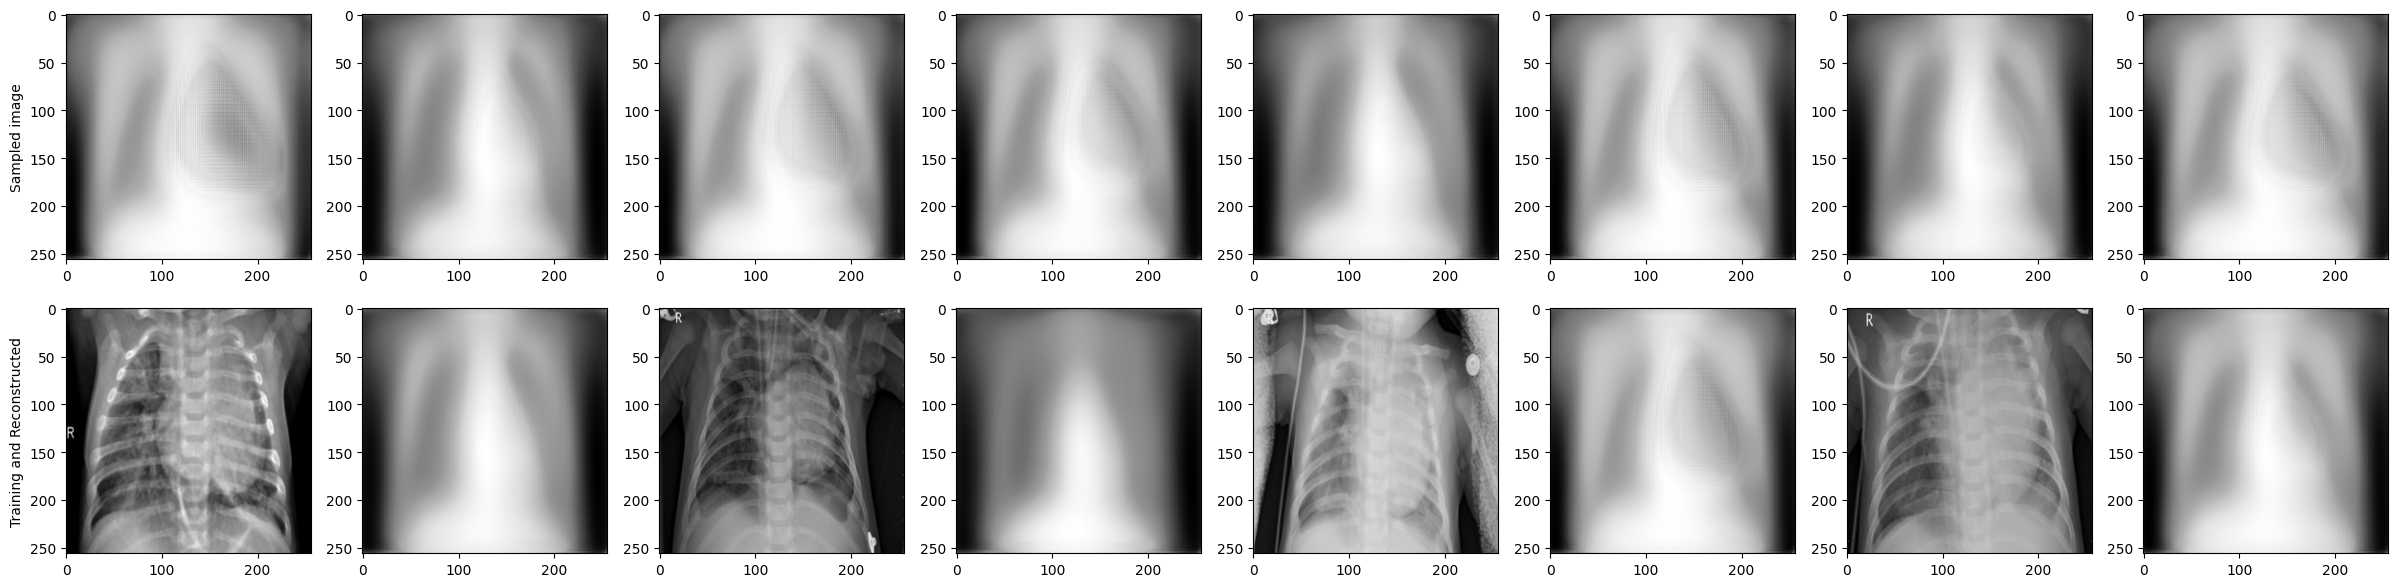

Starting evaluation...


In [9]:
for epoch in trange(1,  22):
    train_loss_kl, train_loss_mse = train(model, train_loader, optimizer, epoch, device, kl_weight=0.3)
    losses.append((train_loss_kl, train_loss_mse))

    if epoch % 3 == 0:
        show_images(model, device, test_loader, num_imgs=8)
        fid_scores.append(get_fid(test_loader, device, evaluation_step))

        model.train()

    if log and epoch % log_iter == 0:
        with torch.no_grad():
            sample = torch.randn(4, latent_len, 1, 1).to(device)
            sample = model.D(sample).cpu()
            wandb.log({"image": [wandb.Image(sample.view(4, n_channels, img_size, img_size))]})


plot_losses_and_fid(losses, fid_scores)

In [ ]:
# save model
torch.save(model.state_dict(), 'vae.pth')

## Test

In [7]:
## Load test data
test_args = Args()
test_args.imagePath = '/root/data/data/chest_xray/test/PNEUMONIA'
test_dataset = custom_loaders.get_data_loader(test_args)

100%|██████████| 390/390 [00:03<00:00, 128.79it/s]


In [8]:
## load model
bs = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_len = 256
channelsD = [latent_len, 256, 256, 256, 128, 128, 64, 32, n_channels]
channelsE = [n_channels, 64, 64, 128, 128, 256, 256, 512, 2*latent_len]


In [9]:
model = VAE(channelsD, channelsE).to(device)
model.load_state_dict(torch.load('vae.pth'))

model = model.eval()